In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

# Data Preparation

In [104]:
# Load the US Arrest data and inspect the first 5 rows
df = pd.read_csv('USArrests.csv')
df.head()

,Unnamed: 0,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [105]:
# Print the info on the columns in the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  50 non-null     object 
 1   Murder      50 non-null     float64
 2   Assault     50 non-null     int64  
 3   UrbanPop    50 non-null     int64  
 4   Rape        50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB
None


In [106]:
df = df.rename(columns={'Unnamed: 0':'State'})
print(df['State'].unique())

['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'Florida' 'Georgia' 'Hawaii' 'Idaho' 'Illinois'
 'Indiana' 'Iowa' 'Kansas' 'Kentucky' 'Louisiana' 'Maine' 'Maryland'
 'Massachusetts' 'Michigan' 'Minnesota' 'Mississippi' 'Missouri' 'Montana'
 'Nebraska' 'Nevada' 'New Hampshire' 'New Jersey' 'New Mexico' 'New York'
 'North Carolina' 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania'
 'Rhode Island' 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah'
 'Vermont' 'Virginia' 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']


In [107]:
# Drop any duplicates
df = df.drop_duplicates()

## Data Summary:

Each row of the data represents a state. For each state, the variables available are the number of arrests per 100000 residents for the following crimes: murder, assault and rape. There is also a variable for the % of population living in urban areas
There is no null data in any of the columns and all of the quantitative variables are either in float or int format. There is no missing values or duplicates in the States' names. 
The only cleaning of the data was to rename the State column and dropping any potential duplicates.

# PCA

In [108]:
# Create and print the correlation matrix
corr_matrix = df.corr()
print(corr_matrix)

            Murder   Assault  UrbanPop      Rape
Murder    1.000000  0.801873  0.069573  0.563579
Assault   0.801873  1.000000  0.258872  0.665241
UrbanPop  0.069573  0.258872  1.000000  0.411341
Rape      0.563579  0.665241  0.411341  1.000000


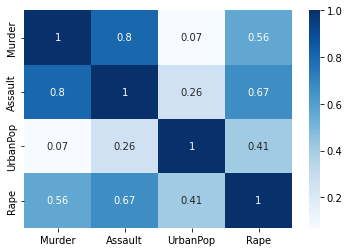

In [109]:
# Visualise the correlation matrix using a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.show()

### All of the crime rates seem to be positively correlated. Especially there is a high correlatio between murder and assault. The urban population variable seem to only be correlated with rape rates.

In [110]:
# Scale the features using the standard scaler
scaler = StandardScaler()
scaler.fit(df.iloc[:,1:])
df_scaled = scaler.transform(df.iloc[:,1:])

In [111]:
# Separate the feature data
X = df_scaled

# Create a PCA model for 3 components (to reduce the number of variables by 1)
pca = PCA(n_components=3)

# Fit the model with the quantitative variables to obtain components
principal_components = pca.fit_transform(X)

# Transform the components into a pandas data frame
pca_df = pd.DataFrame(principal_components)

# Inspect the data
pca_df.head()

,0,1,2
0,0.985566,1.133392,-0.444269
1,1.950138,1.073213,2.040003
2,1.763164,-0.745957,0.054781
3,-0.141420,1.119797,0.114574
4,2.523980,-1.542934,0.598557


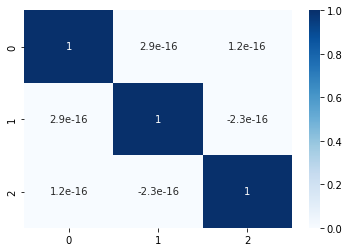

In [112]:
# Create and visualise a new correlation matrix using the principal components
corr_matrix_pca = pca_df.corr()
sns.heatmap(corr_matrix_pca, annot=True, cmap='Blues')
plt.show()

### After implementing PCA and reducing the variables to three primary components, the positive correlations between the variables are eliminated. 

# Hierarchical Clustering

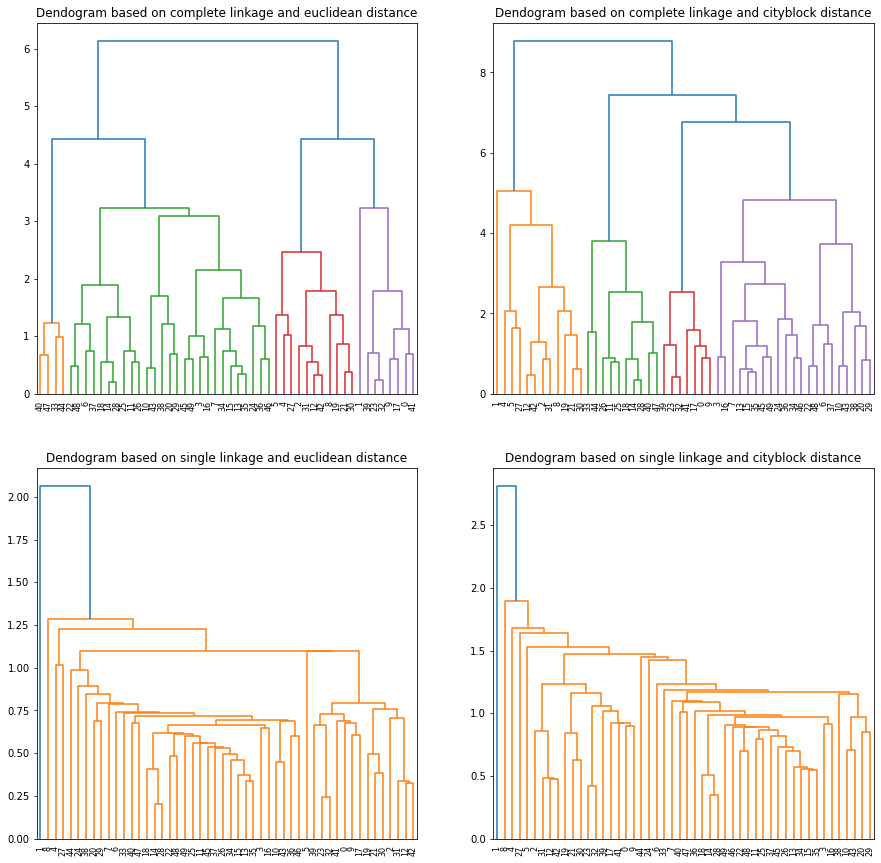

In [113]:
# Create lists of linkage types and distance measurements to check
linkage_types = ['complete', 'single']
distance_measure = ['euclidean', 'cityblock']

# Plot dendograms for all combinations of linkage and distance measurement to select the best split
plt.figure(figsize=[15,15])
count = 0
for l in linkage_types:
    for m in distance_measure:
        count += 1
        plt.subplot(2, 2, count)
        dend = dendrogram(linkage(pca_df, method=l, metric=m))  
        plt.title('Dendogram based on {} linkage and {} distance'.format(l,m))
plt.show()

### The best defined dendogram seems to be the dendogram based on complete linkage and cityblock distance

In [114]:
# Create a model based on complete linkage and cityblock distance for four clusters
cluster = AgglomerativeClustering(n_clusters=4, metric='cityblock', linkage='complete')
# Get cluster allocations based on the model
clusters = cluster.fit_predict(pca_df)

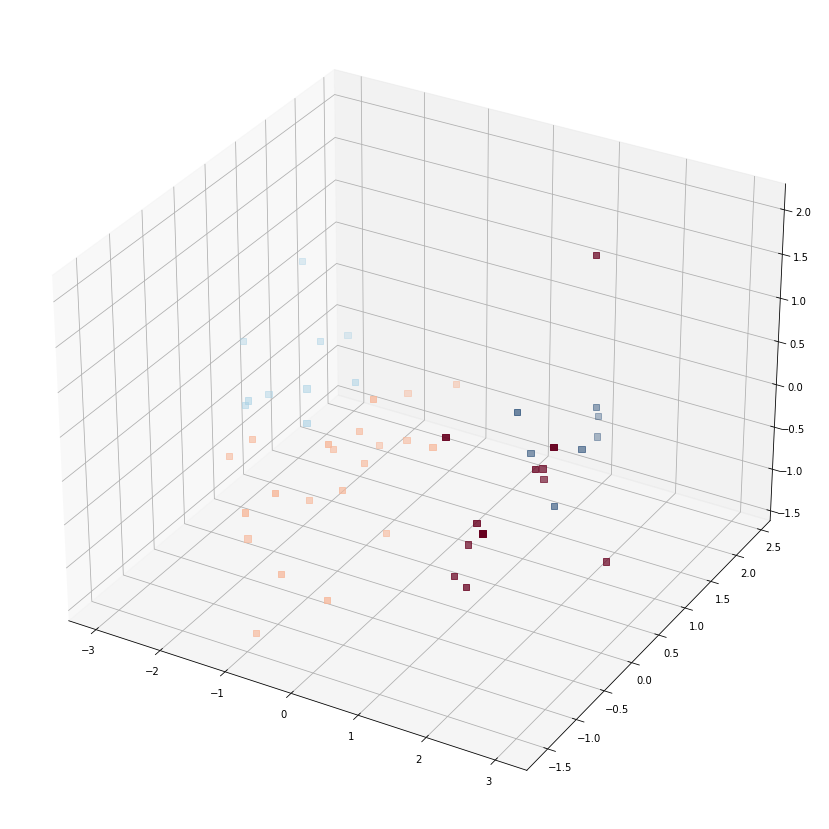

In [115]:
# Create a 3D scatterplot to visualise the clusters across the 3 primary components
fig = plt.figure(figsize=[15,15])
ax = fig.add_subplot(111, projection='3d')
x = np.array(pca_df[0])
y = np.array(pca_df[1])
z = np.array(pca_df[2])

ax.scatter(x,y,z, marker="s", c=clusters, s=40, cmap="RdBu")

plt.show()

In [125]:
# Add the clusters column into the original dataframe
df['Cluster'] = clusters

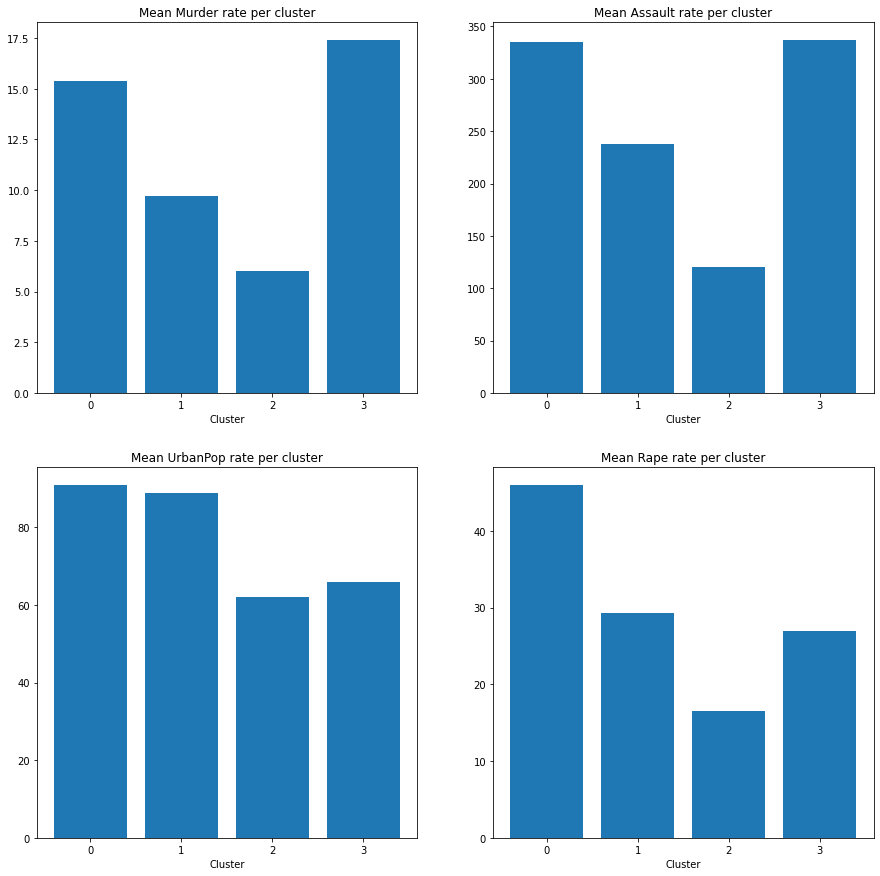

In [126]:
# Get means for all quantitative variables grouped by cluster
cluster_grouped = df.iloc[:,1:].groupby('Cluster').mean().reset_index()

# Create bar charts to compare the means of crime rates and urban population % between the clusters
plt.figure(figsize=[15,15])
count = 0
for metric in list(df.columns)[1:5]:
    count += 1
    plt.subplot(2, 2, count)
    plt.bar(df['Cluster'], df[metric])
    plt.title(f'Mean {metric} rate per cluster')
    plt.xticks([0,1,2,3])
    plt.xlabel('Cluster')
plt.show()

### The clusters seem to be as follows:
#### Cluster 0 has high rates for all crime types and also for the % urban population. This cluster likely contains states with lower socioeconomical status regions, high in crime and urbanised areas. For example New York and California. 
#### Cluster 1 also has a high % of urban population but the rates for all crime types are medium. This cluster likely contains more well off and urbanised states. For example New Jersey and Washington.
#### Cluster 2 has the lowest rates of all crimes and the lowest % of urban population. This cluster likely contains more rural and well off states. For example Maine and Vermont.
#### Cluster 3 has highest rates of murder and assault but the % living in urban areas is on the lower end and rape rates are medium. This cluster likely contains more rural states but with lower socioeconomical status regions. For example Luisiana and Alabama. It seems most States in this cluster are Sauthern states.

In [127]:
# Check the silhouette score of the model
silhouette_score(pca_df, cluster.fit_predict(pca_df))

0.3453006946518956

### The silhouette score seems to be on the lower end, meaning the clusters overlap.

# KMeans Clustering

In [128]:
# Create the clustering model
kmeans = KMeans(n_clusters=4)
kmeans.fit(pca_df)

# Predict the clusters
clusters_kmeans = kmeans.fit_predict(pca_df)

/Users/joannascharoch/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/joannascharoch/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


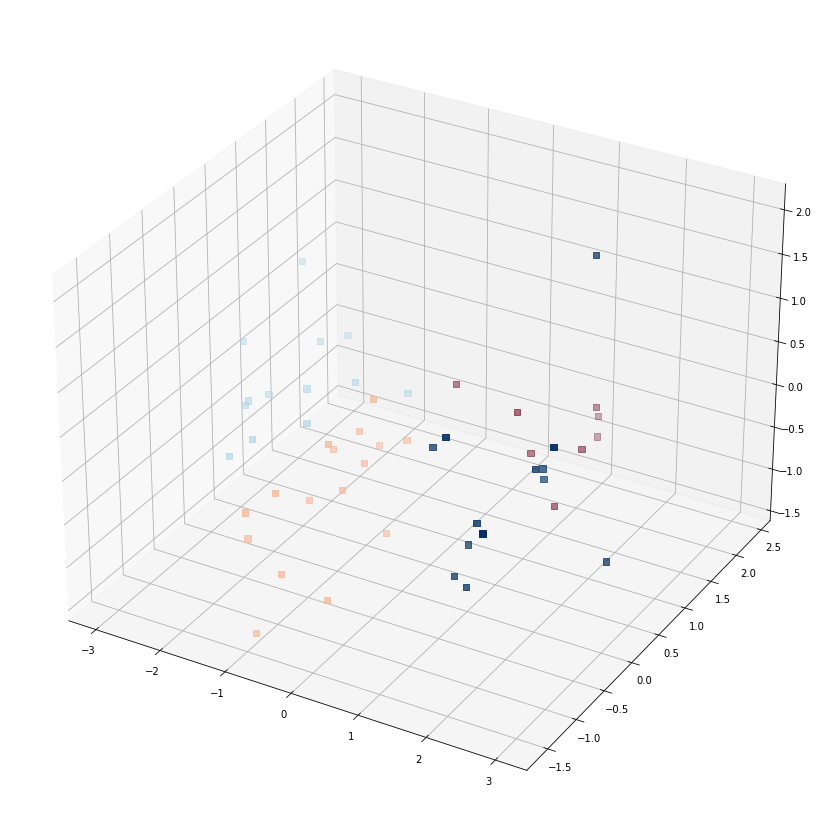

In [129]:
# Create a 3D scatterplot to visualise the clusters across the 3 primary components
fig = plt.figure(figsize=[15,15])
ax = fig.add_subplot(111, projection='3d')
x = np.array(pca_df[0])
y = np.array(pca_df[1])
z = np.array(pca_df[2])

ax.scatter(x,y,z, marker="s", c=clusters_kmeans, s=40, cmap="RdBu")

plt.show()

In [130]:
# Add a column for KMeans clusters into the original dataframe
df['Clusters KMeans'] = clusters_kmeans

In [131]:
# Check the silhouette score of the model
silhouette_score(pca_df, kmeans.fit_predict(pca_df))

/Users/joannascharoch/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.371598266830226

### Silhouette scores seems to be slightly better than in the hierarchical clustering, however, still on the lower end.

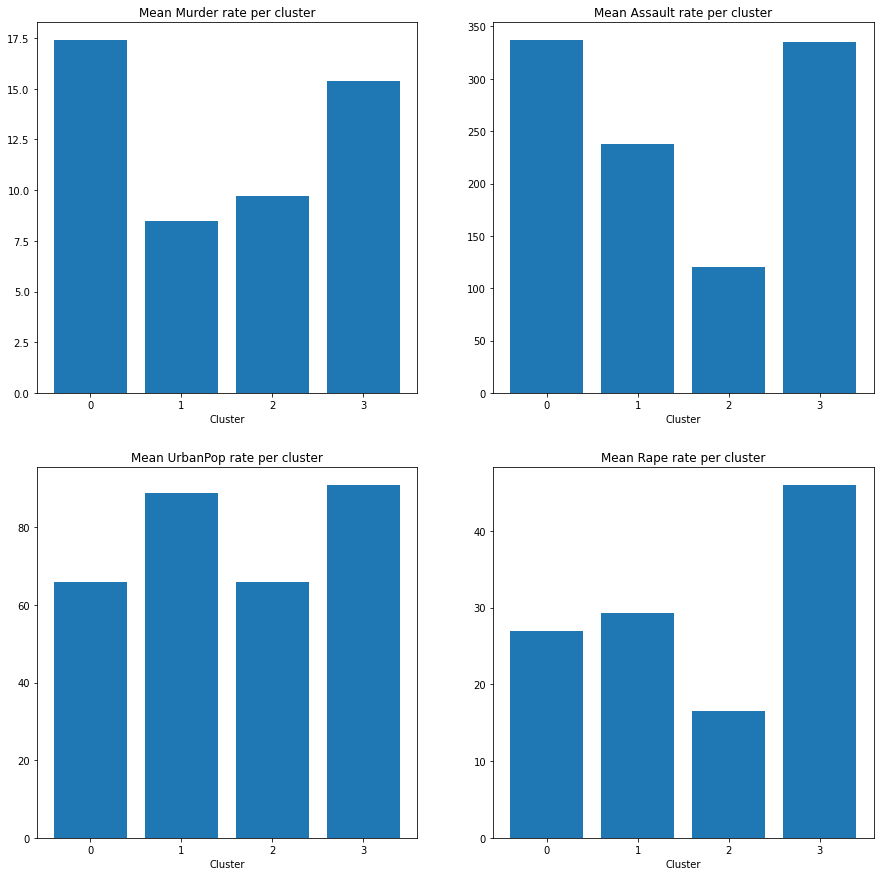

In [132]:
# Get means of all quantitative variables by cluster
cluster_kmeans_grouped = df[['Murder', 'Assault', 'UrbanPop', 'Rape', 'Clusters KMeans']].groupby('Clusters KMeans').mean().reset_index()

# Create bar charts to compare the means of crime rates and urban population % between the clusters
plt.figure(figsize=[15,15])
count = 0
for metric in ['Murder', 'Assault', 'UrbanPop', 'Rape']:
    count += 1
    plt.subplot(2, 2, count)
    plt.bar(df['Clusters KMeans'], df[metric])
    plt.title(f'Mean {metric} rate per cluster')
    plt.xticks([0,1,2,3])
    plt.xlabel('Cluster')
plt.show()
    

In [133]:
# Inspect the states allocated to each cluster
df.sort_values(by='Cluster')

,State,Murder,Assault,UrbanPop,Rape,Clusters,Clusters KMeans,Cluster
1,Alaska,10.0,263,48,44.5,0,3,0
2,Arizona,8.1,294,80,31.0,0,3,0
27,Nevada,12.2,252,81,46.0,0,3,0
4,California,9.0,276,91,40.6,0,3,0
5,Colorado,7.9,204,78,38.7,0,3,0
19,Maryland,11.3,300,67,27.8,0,3,0
8,Florida,15.4,335,80,31.9,0,3,0
42,Texas,12.7,201,80,25.5,0,3,0
30,New Mexico,11.4,285,70,32.1,0,3,0
21,Michigan,12.1,255,74,35.1,0,3,0


### It appears that the cluster allocation in the KMeans model was similar to the hierarchical model. 
#### Cluster 0 is almost entirely the same models
#### Clusters 1 and 2 are similar however there is an overlap in those two clusters between the models
#### Cluster 3 is almost the same in both models